In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

uploaded the data to cse server to be downloaded by all .ipynb files

In [ ]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [8]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [9]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [10]:
Images = preprocess_images(input_dir)
Images.size()

torch.Size([8091, 3, 224, 224])

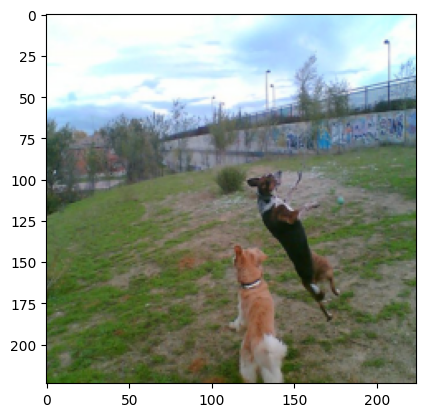

In [11]:
display_image(Images,1)

# Preprocessing Captions

In [12]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [13]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [14]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [15]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [16]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [17]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [18]:
train_split = int(0.8*len(list_of_files))
val_split = ((len(list_of_files) - train_split)//2 )
test_split = len(list_of_files) - train_split - val_split

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:train_split+val_split]
test_files = list_of_files[train_split+val_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:train_split+val_split,:,:,:]
test_images = Images[train_split+val_split:,:,:,:]


In [19]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [20]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> man dressed in gray gear <end>', '<start> man in black uniform and helmet dirtracing with his bike front wheel in midair <end>', '<start> man riding dirt bike <end>', '<start> motorcycle racer is in action at the track <end>', '<start> biker riding dirt bike on dirt track <end>']


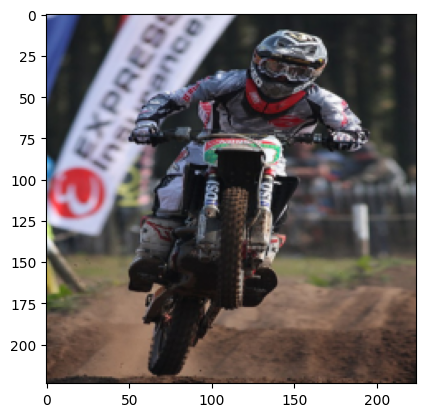

In [21]:
print(train_captions[0])
display_image(train_images,0)

In [22]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7777
6472
6472


# Captions Dataset

In [23]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [24]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [25]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [26]:
class CNN_model_1(nn.Module):
    #vgg 19
    def __init__(self, embed_size):
        super(CNN_model_1, self).__init__()
        vgg = models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad_(False)

        modules = list(vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)
        self.embed = nn.Linear(25088, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        return self.embed(features)


In [27]:
from torchvision.models.resnet import resnet152
class CNN_model_2(nn.Module):
  # ResNet model
  def __init__(self,embed_size):
    super(CNN_model_2,self).__init__()
    resnet = models.resnet152(pretrained = True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features,embed_size)
    self.linear.weight.data.normal_(0.0, 0.02)
    self.linear.bias.data.fill_(0)

  def forward(self, images):
    features = self.resnet(images)
    # print(features.shape)
    features = features.reshape(features.size(0), -1)
    # print(features.shape)
    return self.linear(features)

# LSTM and Transformer part of the decoder

In [28]:
class DecoderNet(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(DecoderNet, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return weighted_encoding, alpha

In [29]:
import torch
import torch.nn as nn

class LSTM_model_2(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, net_dim, n_layers=1):
        super(LSTM_model_2, self).__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.net_dim = net_dim
        self.n_layers = n_layers
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.net = DecoderNet(hidden_dim, hidden_dim, net_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embeddings(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        lstm_out, _ = self.lstm(inputs, (hidden, cell))
        encoding, _ = self.net(lstm_out, features.unsqueeze(1))
        output = self.linear(encoding)

        return output

    def sample(self, features, max_len=40):
        inputs = features
        sampled_captions = []
        hidden = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)
        cell = torch.zeros(self.n_layers, len(inputs), self.hidden_dim).to(features.device)

        for _ in range(max_len):
            lstm_out, (hidden, cell) = self.lstm(inputs, (hidden, cell))
            attended_encoding, _ = self.net(lstm_out, features.unsqueeze(1))
            output = self.linear(attended_encoding)
            output = output.squeeze(1).squeeze(1)
            predicted_indices = output.max(dim = 1)[1]
            sampled_captions.append(predicted_indices.item())
            inputs = self.embeddings(predicted_indices.unsqueeze(1))

        return sampled_captions


# Integrating the 2 parts of the model

In [30]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs = self.decoder(features,captions)
    return features,outputs

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.sample(features)
    return prediction


In [31]:
def generate_captions(model,image):
  model.eval()
  predicted_captions = model.evaluate_and_sample(image)
  sentence = ""
  for idx in predicted_captions:
    word = vocab[0][idx]
    if word != "<end>" and word != '<start>':
      sentence += vocab[0][idx] + " "
    elif word == '<end>':
      break
  return sentence

In [32]:
def validate(model):
  actual_captions = []
  generated_captions = []
  for data in val_loader:
    image, caption_set = data
    # print(image,caption_set)
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(generate_captions(model,image).split())
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  return bleu

In [33]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for i,(img,cap,caplen) in tqdm(enumerate(train_loader)):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap.view(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = model
              best_bleu = bleu
      return model,best_checkpoint_model

# Calling Functions

In [34]:
learning_rate = 0.0001
num_epochs = 10
embed_size=512
hidden_size=512
net_size = 512
vocab_size=len(vocab[0])
n_layers=2

In [35]:
decoder = LSTM_model_2(embed_size, hidden_size, vocab_size, net_size, n_layers)
encoder = CNN_model_1(embed_size=embed_size)
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.4MB/s]


In [36]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [37]:
best_checkpoint_model,final_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs)

6472it [02:19, 46.39it/s]


Epoch [1/10], Loss: 4.4889, Perplexity: 89.0265
BLEU-1: 0.372038141251917
BLEU-2: 0.17965427257693517
BLEU-3: 0.08701815696089582
BLEU-4: 0.04379755422760378
BLEU:0.1263342739995843
checkpointing best model


6472it [02:16, 47.47it/s]


Epoch [2/10], Loss: 3.8223, Perplexity: 45.7072
BLEU-1: 0.3685403314482086
BLEU-2: 0.17733089098089003
BLEU-3: 0.08315150195214743
BLEU-4: 0.04260268151669572
BLEU:0.12335140852967397


6472it [02:16, 47.33it/s]


Epoch [3/10], Loss: 3.5846, Perplexity: 36.0402
BLEU-1: 0.35802066895747786
BLEU-2: 0.18890991645457045
BLEU-3: 0.09502848209312549
BLEU-4: 0.04648759865317793
BLEU:0.13147356528147097
checkpointing best model


6472it [02:18, 46.90it/s]


Epoch [4/10], Loss: 3.4566, Perplexity: 31.7095
BLEU-1: 0.36357611031988757
BLEU-2: 0.19404184418086873
BLEU-3: 0.1066130014573011
BLEU-4: 0.059393409054079194
BLEU:0.14538171545410356
checkpointing best model


6472it [02:17, 46.93it/s]


Epoch [5/10], Loss: 3.3468, Perplexity: 28.4104
BLEU-1: 0.3320335472073705
BLEU-2: 0.16867588440860842
BLEU-3: 0.08718867888893185
BLEU-4: 0.04407732988121248
BLEU:0.12112326914827849


6472it [02:18, 46.89it/s]


Epoch [6/10], Loss: 3.2472, Perplexity: 25.7172
BLEU-1: 0.34527124145506355
BLEU-2: 0.19079456370852907
BLEU-3: 0.10706909097157398
BLEU-4: 0.057681130289648073
BLEU:0.14202214577847344


6472it [02:17, 46.99it/s]


Epoch [7/10], Loss: 3.1941, Perplexity: 24.3886
BLEU-1: 0.3207343292512197
BLEU-2: 0.1758180514290369
BLEU-3: 0.09787982629679094
BLEU-4: 0.05326935989726628
BLEU:0.1309468013262134


6472it [02:18, 46.81it/s]


Epoch [8/10], Loss: 3.1129, Perplexity: 22.4863
BLEU-1: 0.3365752003849709
BLEU-2: 0.17488501510580629
BLEU-3: 0.09057144231771273
BLEU-4: 0.04855075728571709
BLEU:0.1268397861101104


6472it [02:17, 47.02it/s]


Epoch [9/10], Loss: 3.0432, Perplexity: 20.9727
BLEU-1: 0.3286959816545623
BLEU-2: 0.1822587449683924
BLEU-3: 0.10646777613277099
BLEU-4: 0.05958346160967259
BLEU:0.13962290538985622


6472it [02:18, 46.80it/s]


Epoch [10/10], Loss: 3.0052, Perplexity: 20.1906
BLEU-1: 0.3532772173533467
BLEU-2: 0.18703169861761162
BLEU-3: 0.10054849629195182
BLEU-4: 0.053904991487972516
BLEU:0.13756528515438002


# Generating Captions

In [38]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions = generate_captions(model,image)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)

man in black and black pants is standing on the beach 


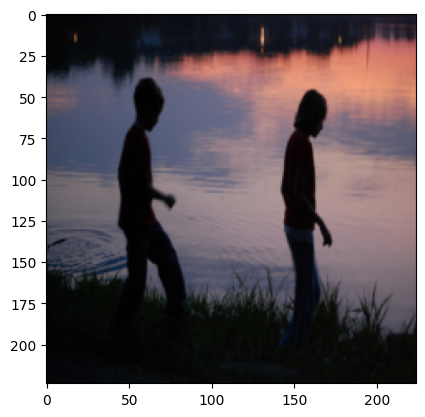

In [39]:
generate_captions_for_random_image(model)

girl in pink dress is smiling 


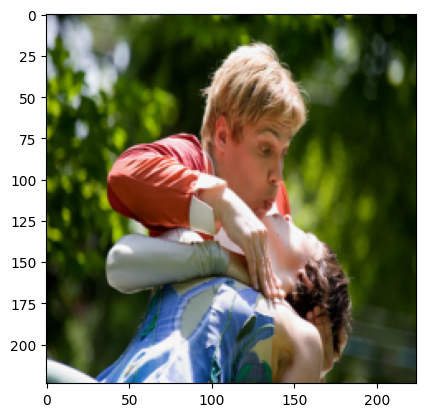

In [40]:
generate_captions_for_random_image(model)

dog is running through the snow 


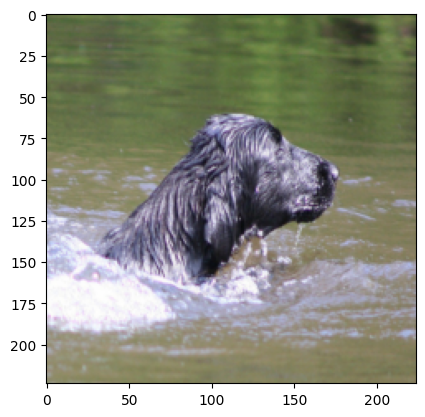

In [41]:
generate_captions_for_random_image(model)

two dogs are playing in the grass 


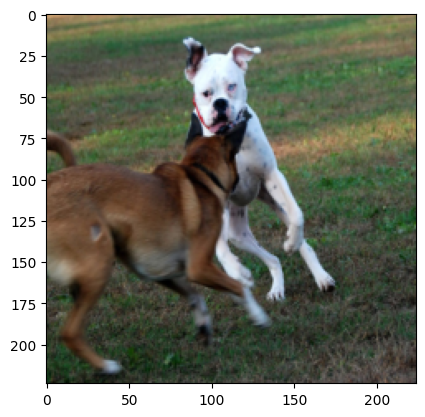

In [48]:
generate_captions_for_random_image(model)

two men are playing basketball 


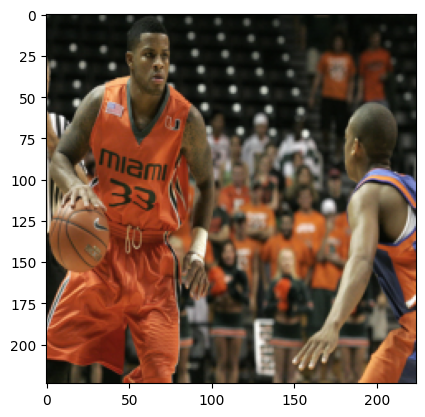

In [49]:
generate_captions_for_random_image(model)

dog runs through the grass 


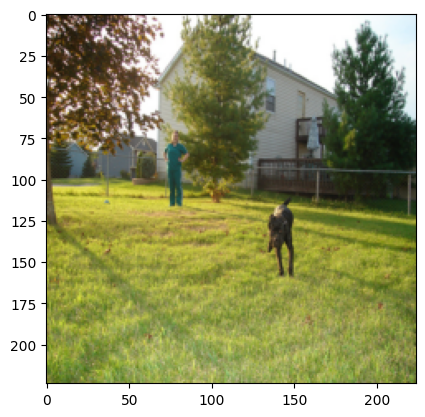

In [56]:
generate_captions_for_random_image(model)